In [26]:
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
import edlib
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
import ipywidgets as widgets
from collections import Counter
import panel as pn
import warnings
warnings.filterwarnings('ignore')


In [28]:
### Provide email address to NCBI
Entrez.email = "mrmalik@ucdavis.edu"

def fetch_sequence(accession):
    ### Fetch sequence from NCBI with accession number
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta")
    record = SeqIO.read(handle, "fasta")
    handle.close()
    return record

### Create two lists for two different ways to identify hominids in the code that follows.

names = ['European Neanderthal', 'European Human', 'Altai Denisovan', 'Sumatran Orangutan',
         'Bornean Orangutan', 'Western Lowland Gorilla', 'Eastern Lowland Gorilla', 'Bonobo',
         'Chimp Schweinfurthii', 'Chimp Ellioti', 'Chimp Verus', 'Chimp Troglodytes']


numbers = ['NC_011137','NC_012920','FN673705','NC_002083',
            'NC_001646','NC_011120','KM242275','NC_001644',
            'JF727201','KM679417','JF727217','JF727180']

### Now create a dataframe using the accession numbers to retrieve the sequences.

hominids = dict()
index = 0
for accession_number in numbers:
    sequence_record = fetch_sequence(accession_number)
    sequence = str(sequence_record.seq)
    hominids[names[index]] = sequence.strip()
    index += 1

df = pd.DataFrame(list(hominids.items()), columns=['Species', 'mtDNA'])

lengths = []
for seq in df['mtDNA']:
     length = len(seq)
     lengths.append(length)
df['Length'] = lengths

df2 = df[['Species', 'Length', 'mtDNA']]

df

,Species,mtDNA,Length
0,European Neanderthal,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16565
1,European Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16569
2,Altai Denisovan,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16570
3,Sumatran Orangutan,GTTTATGTAGCTTATTCTATCCAAAGCAATGCACTGAAAATGTCTC...,16499
4,Bornean Orangutan,GTTTATGTAGCTTATTCCATCCAAAGCAATACACTGAAAATGTCTC...,16389
5,Western Lowland Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16412
6,Eastern Lowland Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16416
7,Bonobo,GTTTATGTAGCTTACCCCCTTAAAGCAATACACTGAAAATGTTTCG...,16563
8,Chimp Schweinfurthii,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16560
9,Chimp Ellioti,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16559


In [29]:
def kmer_freq(seq, k):
    
    ### This segments mtDNA into k-mer substrings of length k
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    counts = Counter(kmers)
    total_kmers = sum(counts.values())
    return {kmer: counts[kmer] / total_kmers for kmer in counts}

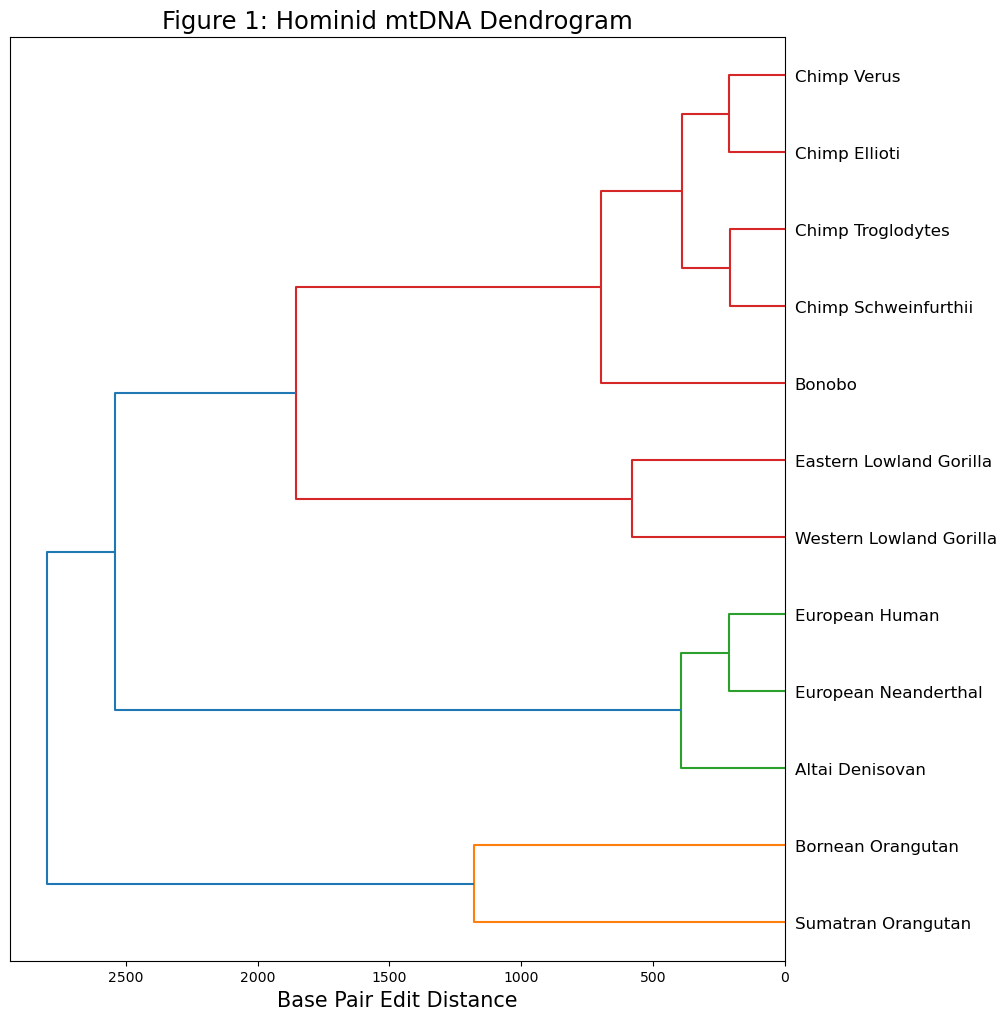

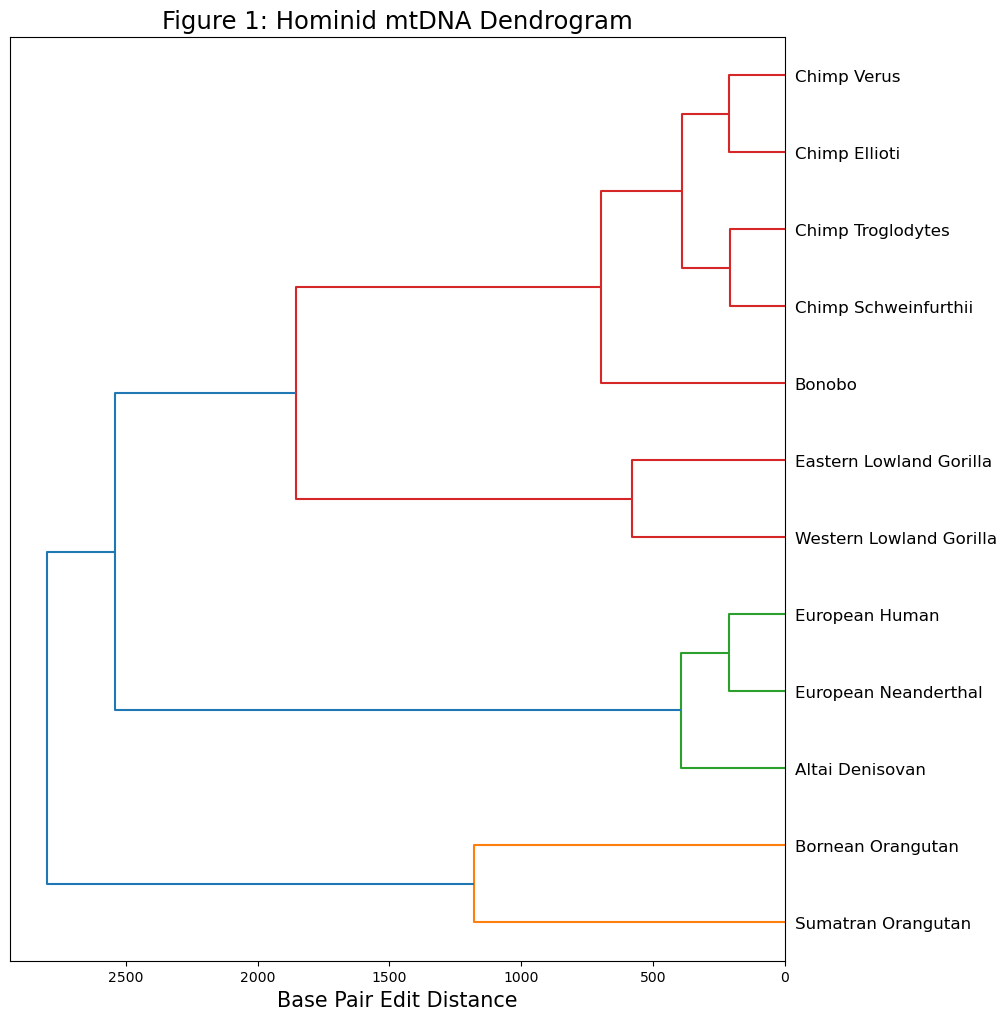

In [30]:
def figure1():
    
    names = df['Species']
    hominids = {names[i]: df['mtDNA'][i] for i in range(len(names))}

    ### Using the dictionary, we iteratively run edit distance on every combination of species.
    ### First set up matrix for edit distances
    ds_mat = np.zeros((len(names), len(names)))

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            result = edlib.align(hominids[names[i]], hominids[names[j]], task='distance')
            edit_ds = result['editDistance']
            ds_mat[i, j] = ds_mat[j, i] = edit_ds

    ### Dendrogram
    condensed_dist_mat = ssd.squareform(ds_mat)
    linkage_matrix = sch.linkage(condensed_dist_mat, method='average')

    fig, ax = plt.subplots(figsize=(10, 12))
    dendro = sch.dendrogram(linkage_matrix, labels=names.to_numpy(), orientation='left', ax=ax)

    ax.set_title('Figure 1: Hominid mtDNA Dendrogram', fontsize='17.5')
    ax.set_xlabel('Base Pair Edit Distance', fontsize='15')
    plt.show
    return fig

figure1()

In [31]:
def figure2():
    
    names = df['Species']
    hominids = {names[i]: df['mtDNA'][i] for i in range(len(names))}

    ### Using the dictionary, we iteratively run edit distance on every combination of species.
    ### First set up matrix for edit distances
    ds_mat = np.zeros((len(names), len(names)))

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            result = edlib.align(hominids[names[i]], hominids[names[j]], task='distance')
            edit_ds = result['editDistance']
            ds_mat[i, j] = ds_mat[j, i] = edit_ds
    
    names = ['European Neanderthal', 'Altai Denisovan', 'Sumatran Orangutan',
             'Bornean Orangutan', 'Western Lowland Gorilla', 'Eastern Lowland Gorilla', 'Bonobo',
             'Chimp Schweinfurthii', 'Chimp Ellioti', 'Chimp Verus', 'Chimp Troglodytes']


    extract1 = ds_mat[1]
    extract2 = np.array([extract1[i] for i in range(len(extract1)) if i != 1])
    
    data = pd.DataFrame({'Species': names, 'Edit Distance': extract2})
    data = data.sort_values('Edit Distance', ascending=False)
    
    bar_plot = data.hvplot.barh(
        x='Species', y='Edit Distance', color='black', 
        hover_cols=['Edit Distance'], title="Figure 2: Edit Distance to Human Mitochondrial Genome",
        height=600, width=600
    )
    
    return bar_plot

figure2()


:Bars   [Species]   (Edit Distance)

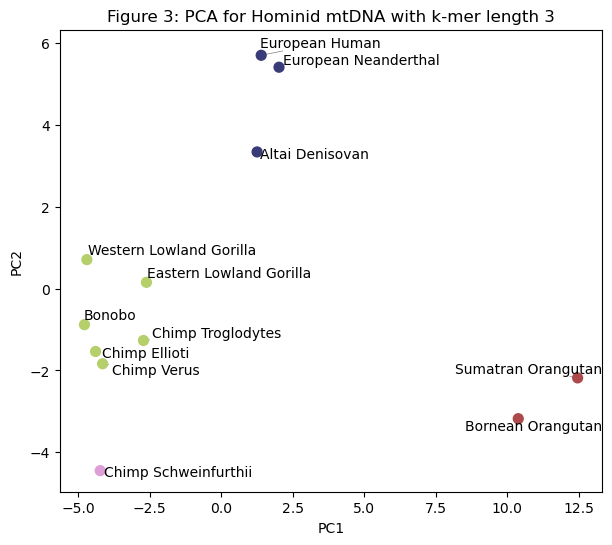

interactive(children=(IntSlider(value=3, description='k-mer length:', max=9, min=3), Output()), _dom_classes=(…

In [32]:
def figure3(k):
    
    ### Compute k-mer frequency for each mitochondrial genome
    df['kmer_freq'] = df['mtDNA'].apply(lambda seq: kmer_freq(seq, k))
    all_kmers = set()
    for kmer_counts in df['kmer_freq']:
        all_kmers.update(kmer_counts.keys())

    ### Turn data into feature matrix
    kmer_features = pd.DataFrame([{kmer: kmer_dict.get(kmer, 0) for kmer in all_kmers} for kmer_dict in df['kmer_freq']])
    scaler = StandardScaler()
    kmer_features_scaled = scaler.fit_transform(kmer_features)

    ### PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_features_scaled)
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Species'] = df['Species']
    
    ### K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    pca_df_2 = pca_df[['PC1', 'PC2']]
    kmeans.fit(pca_df_2)
    pca_df_2['Genus'] = kmeans.predict(pca_df_2)

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(pca_df['PC1'], pca_df['PC2'], color='black', s=10)
    texts = []
    for i, species in enumerate(pca_df['Species']):
        text = ax.text(pca_df.loc[i, 'PC1'], pca_df.loc[i, 'PC2'], species, fontsize=10)
        texts.append(text)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    scatter = ax.scatter(pca_df_2['PC1'], pca_df_2['PC2'], c=pca_df_2['Genus'], cmap='tab20b', s=50)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"Figure 3: PCA for Hominid mtDNA with k-mer length {k}")
    plt.show()
    return fig

### Interactive Component
slider = widgets.IntSlider(value=3, min=3, max=9, step=1, description="k-mer length:")
interactive_plot = widgets.interactive(figure3, k=slider)
display(interactive_plot)


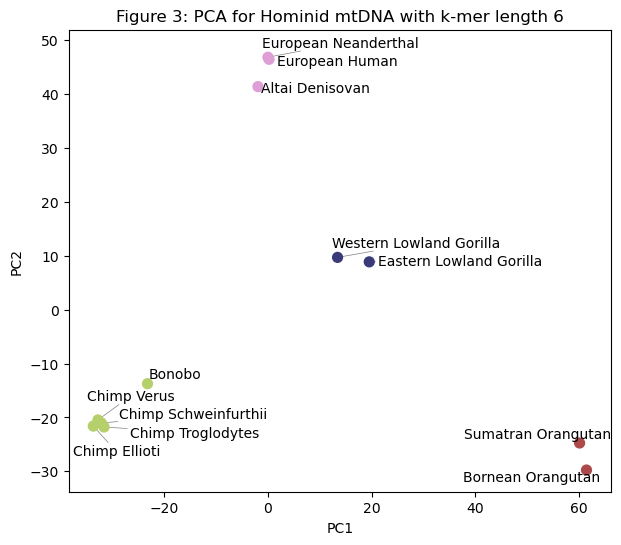

Launching server at http://localhost:63232


FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=2, language='en-US', timezone='America/Los_Angeles', timezone_offset=420, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-5976274128] Row(sizing_mode='fixed')
        [0] HTML(str, height=530, sizing_mode='fixed', width=450)
        [1] Matplotlib(Figure, height=525, sizing_mode='fixed', tight=True, width=600)
    [main-5958508432] Row(sizing_mode='fixed')
        [0] HoloViews(Bars, height=600, sizing_mode='fixed', width=600)
        [1] Column
            [0] Markdown(str)
            [1] IPyWidget(IntSlider)
            [2] Matplotlib(Figure, height=500, sizing_mode='fixed', tight=True, width=500)
    [nav-6049171344] Markdown(str)
    [nav-6041588496] Markdown(str)
    [nav-6058356432] Markdown(str)
    [nav-6067817872] Markdown(str)
    [nav-6048704592] Markdown(str)
    [nav-6041814032] Markdown(str)
    [nav-6041824208] Markdown(str)
    [nav-6049021648] Markdown(str)
    [nav-6041858512] Markdown(str)
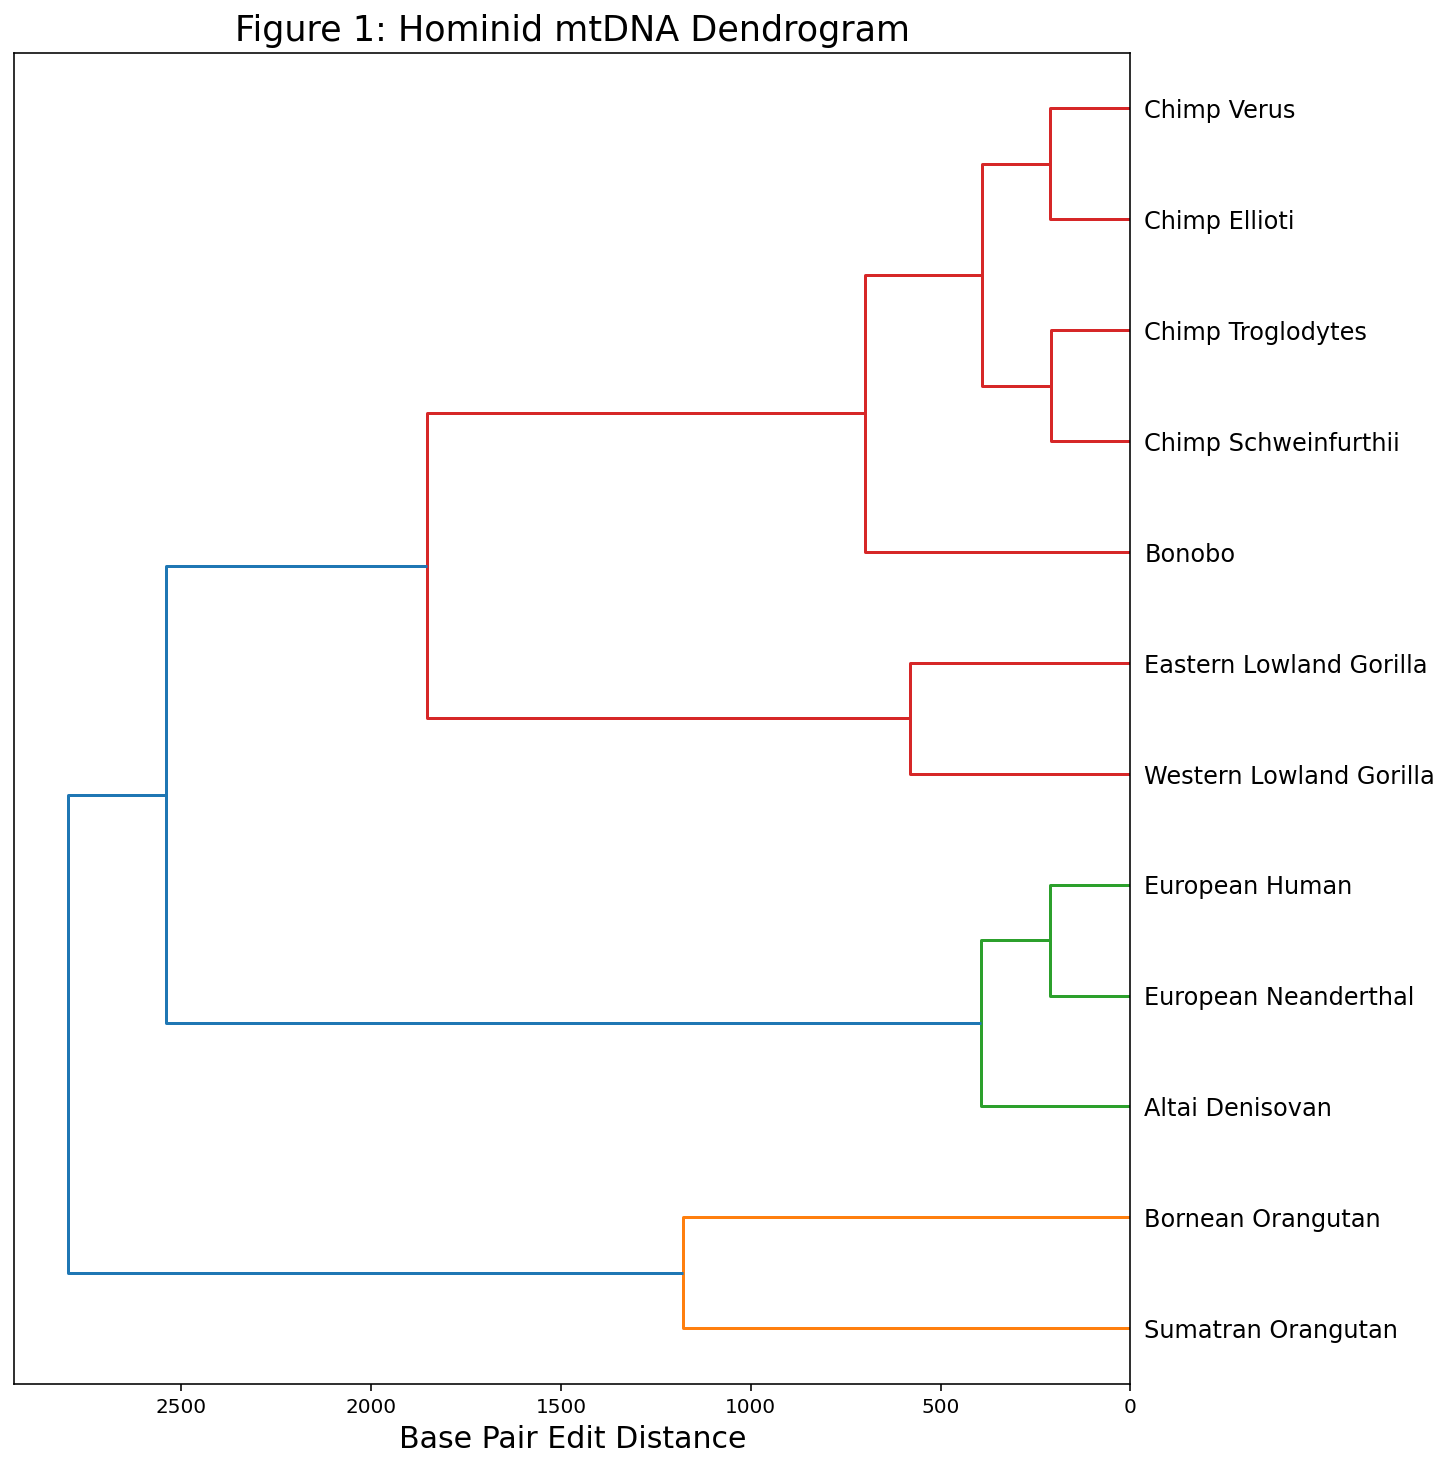
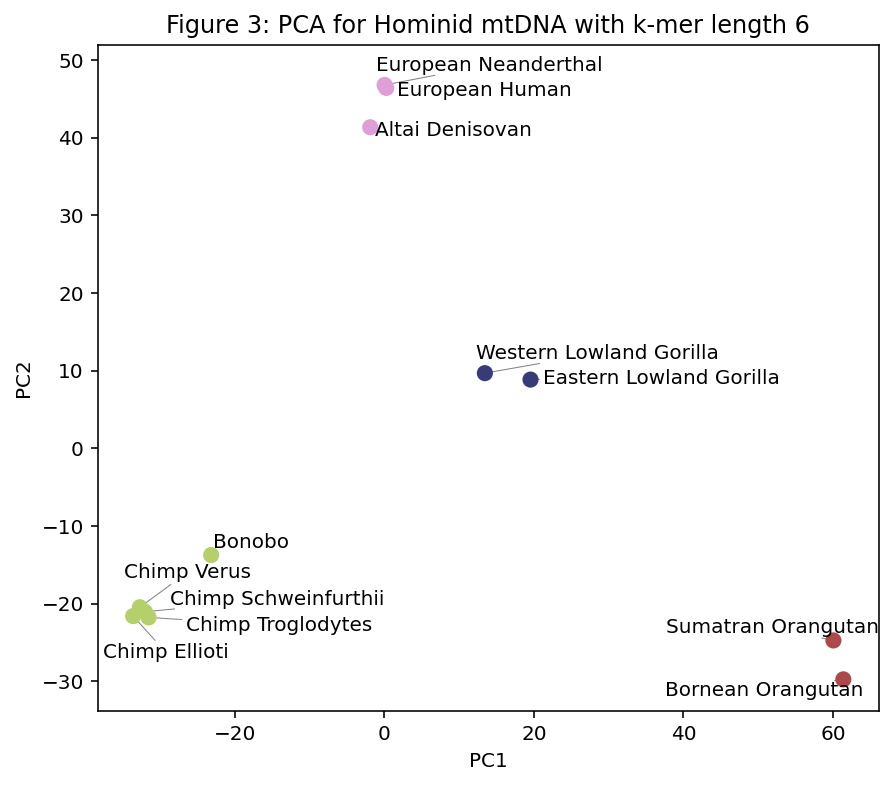

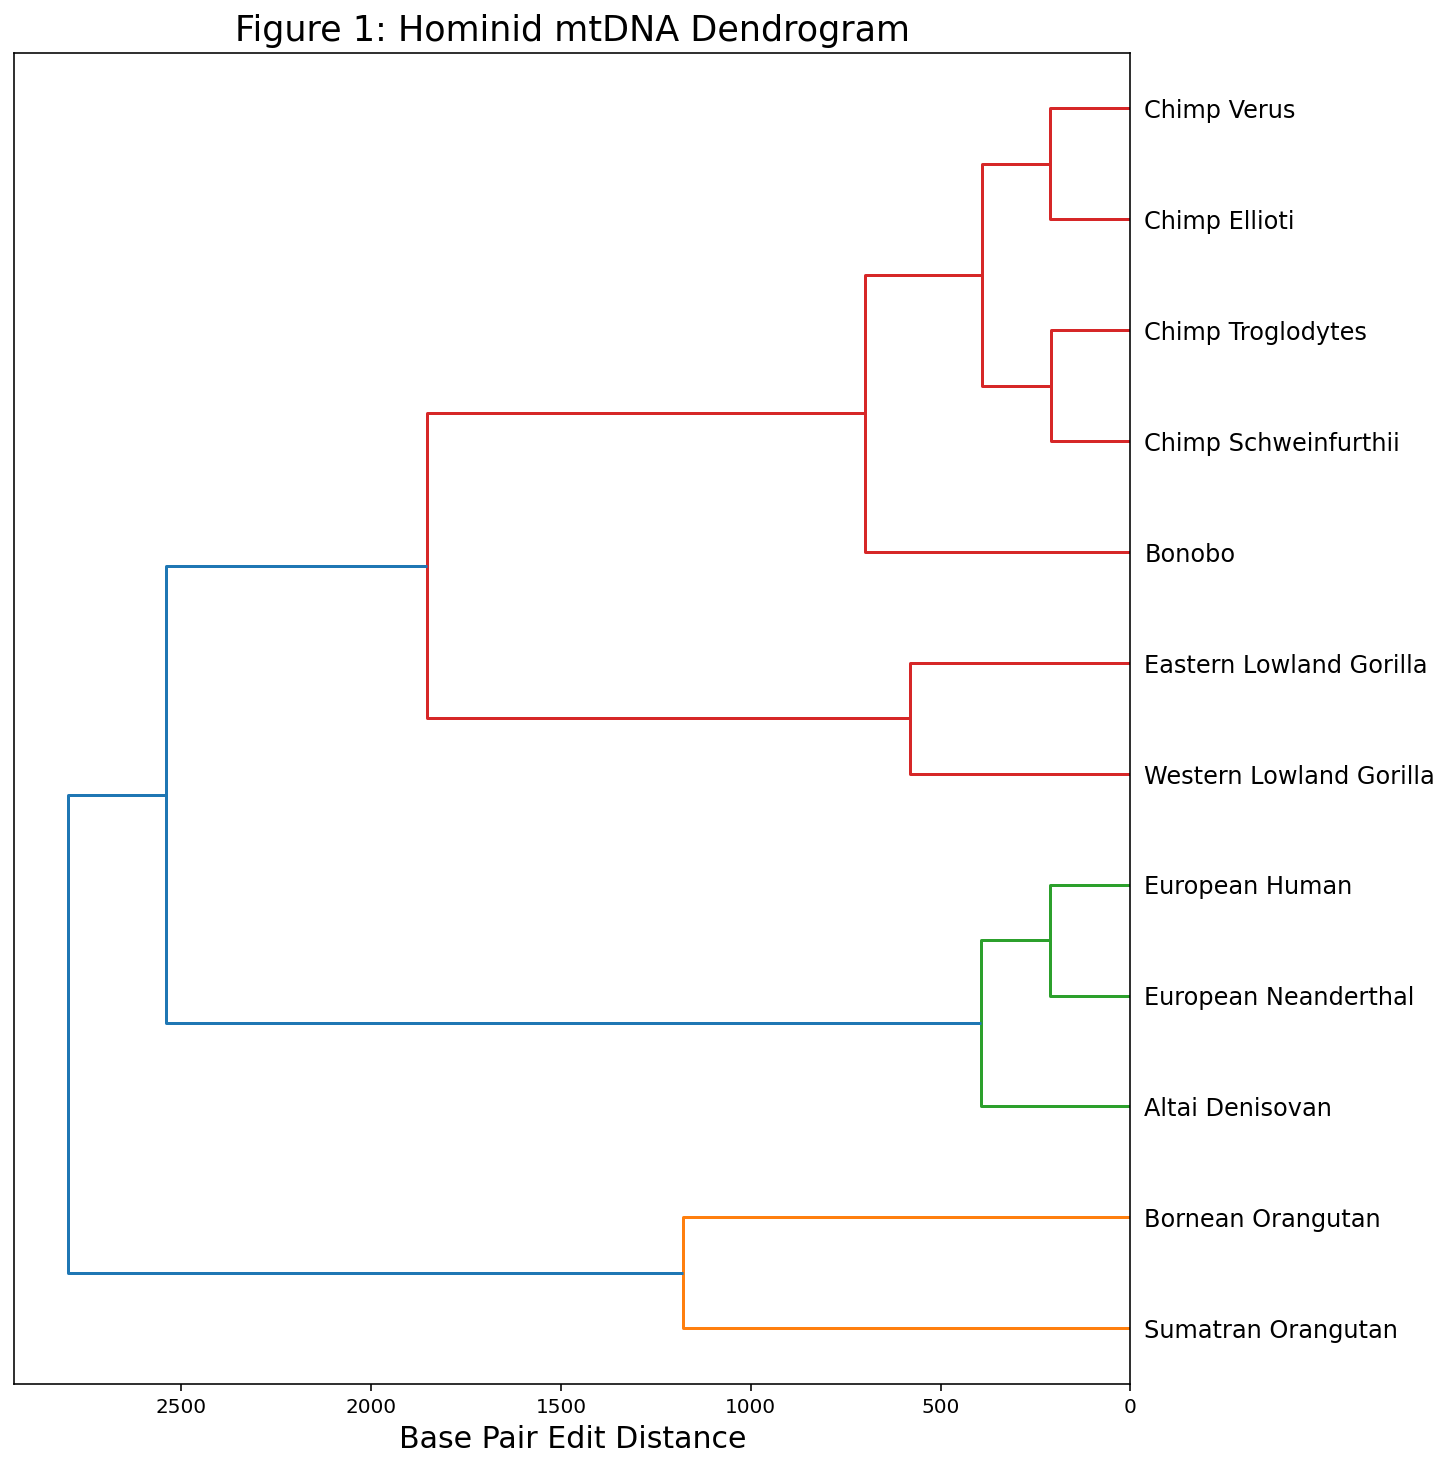

In [33]:
### Data Frame

html_text = df2.to_html(index=False)
html_with_scroll = f"""
<div style="width: 450px; height: 530px; overflow: auto;">
    {html_text}
</div>
"""
html_pane = pn.pane.HTML(html_with_scroll, width=450, height=530)


### Sidebar

sidebar = pn.Column(
    pn.pane.Markdown("#### "),
    pn.pane.Markdown("## Overview"),
    pn.pane.Markdown("#### The mitochondrial genome has long been recognized as a proxy for detecting overall genetic similarity among species that are known to be related when large scale computing resources are not available, like if a fellow has a single macbook to work with or something. Two methods for detecting similarity have been used in this project, (1) edit distance, which is essentially the number of indels or SNPs it would take to transform one genetic sequence into another, and (2) principal component analysis, which we use to compare the genomes after creating a feature matrix and extracting two principal components of its approximation, this after partitioning each genome into k-mers (same-length segments). The (unrelated) k-means clustering algorithm is then applied to the PCA plots with k=4, since we would expect to find clusters for Pongo, Gorilla, Pan, and Homo."), 
    pn.pane.Markdown("### "),
    pn.pane.Markdown("## Key Findings"),
    pn.pane.Markdown("#### Figure 1 does not reflect an accurate phylogram of the genera in question (Gorilla and Homo have swapped places), but it suggests that the mitochondrial genomes of Gorilla and Pan are highly conserved from the MRCA of Homininae, relative to the genomes of Homo. Analyses specifically targeting coding regions may yield more accurate results. Additionally, the Altai Denisovan has been identified as the outgroup of Homo. This is also inaccurate to actual phylogeny but is a well-documented phenomenon."),
    pn.pane.Markdown("#### Figure 2 shows that the mtDNA of members of Pan are still the closest ones to humans, with Gorilla not too far behind, and Pongo the farthest away."),
    pn.pane.Markdown("#### Figure 3 shows the results of PCA and clustering. K-mer lengths 5, 6, and 7 yield a graph that very clearly distinguishes each genus and plots them at relatively equidistant triangle with Gorilla in the middle. Results for 8 and 9 place Homo much closer to Pan."),
    pn.pane.Markdown("## ")
)


### Main Body Layout

slider = widgets.IntSlider(value=6, min=3, max=9, step=1)
figure3_pane = pn.pane.Matplotlib(pn.bind(figure3, slider), tight=True, width=500, height=500)

dashboard = pn.template.FastListTemplate(
    title="Visual Comparison of Hominid Mitochondrial Genomes",
    sidebar=sidebar,
    main=[
        pn.Row(
            #pn.WidgetBox(pn.pane.DataFrame(df2, height=500, width=400,)),
            html_pane,
            pn.pane.Matplotlib(figure1(), tight=True, height=525, width=600),
            sizing_mode="fixed"
        ),
        pn.Row(
            pn.pane.HoloViews(figure2().opts(active_tools=['pan', 'box_zoom'])),
            pn.Column(
                pn.pane.Markdown("### Slide to change k-mer length:"), slider, figure3_pane
            ),
            sizing_mode="fixed"
        )
    ],
    sidebar_width=350,
    header_background="#67bf02",
)



### Display Dashboard

dashboard.show()
dashboard.servable()
